## Setup and imports

In [1]:
# Clone the transformers repository and checkout a specific version
! git clone https://github.com/huggingface/transformers.git
! cd transformers && git checkout v4.57.0
! cd transformers && git tag --points-at HEAD

Cloning into 'transformers'...
Updating files:  27% (1467/5245)
Updating files:  28% (1469/5245)
Updating files:  29% (1522/5245)
Updating files:  30% (1574/5245)
Updating files:  31% (1626/5245)
Updating files:  32% (1679/5245)
Updating files:  33% (1731/5245)
Updating files:  34% (1784/5245)
Updating files:  35% (1836/5245)
Updating files:  36% (1889/5245)
Updating files:  37% (1941/5245)
Updating files:  38% (1994/5245)
Updating files:  39% (2046/5245)
Updating files:  40% (2098/5245)
Updating files:  41% (2151/5245)
Updating files:  42% (2203/5245)
Updating files:  43% (2256/5245)
Updating files:  44% (2308/5245)
Updating files:  44% (2353/5245)
Updating files:  45% (2361/5245)
Updating files:  46% (2413/5245)
Updating files:  47% (2466/5245)
Updating files:  48% (2518/5245)
Updating files:  49% (2571/5245)
Updating files:  50% (2623/5245)
Updating files:  51% (2675/5245)
Updating files:  52% (2728/5245)
Updating files:  53% (2780/5245)
Updating files:  54% (2833/5245)
Updating fil

v4.57.0


In [2]:
# Get git log of changes made after January 1, 2023
! cd transformers && git log --name-only --pretty=format:"%ad - %an: %s" --after="2023-01-01" > ../git_log_output.txt

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from pygount import SourceAnalysis

## Task 1

### Detect defect commits

In [2]:
def get_commit_message(line):
    parts = line.split(": ")
    if len(parts) < 2:
        return ""
    return ": ".join(parts[1:])  # Join back in case there are multiple colons

# Filter git log output for defect-related commits based on the following words
defect_keywords = ["fix", "bug", "error", "issue", "patch"]

defect_commits = []
with open('git_log_output.txt', encoding='utf-8') as infile:
        for line in infile:
            # Check it is a commit line
            if not line[:3] in ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]:
                continue

            message = get_commit_message(line)
            if any(keyword in message.lower() for keyword in defect_keywords):
                defect_commits.append(line)
print(f"Found {len(defect_commits)} defect commits")

Found 3179 defect commits


### Total number of defects per month

In [3]:
month = {
    "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06",
    "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"
}

defect_per_month = {"10/2025": 0}  # initialize with last month in the log: October 2025
# For each defect commit, extract the month and year, and count occurrences
for c in defect_commits:
    parts = c.split()
    # e.g., Mon Nov 10 22:36:21 2025 +0800 - automan: fix qwen2vl/qwen3vl video processor temporal padding when num_frames%temporal_patch_size!=1 (#42083)
    # Month is always on the 2nd position, year is always on the 5th position 
    mon = parts[1]
    year = parts[4]
    if mon in month:
        key = f"{month[mon]}/{year}"
        defect_per_month[key] = defect_per_month.get(key, 0) + 1

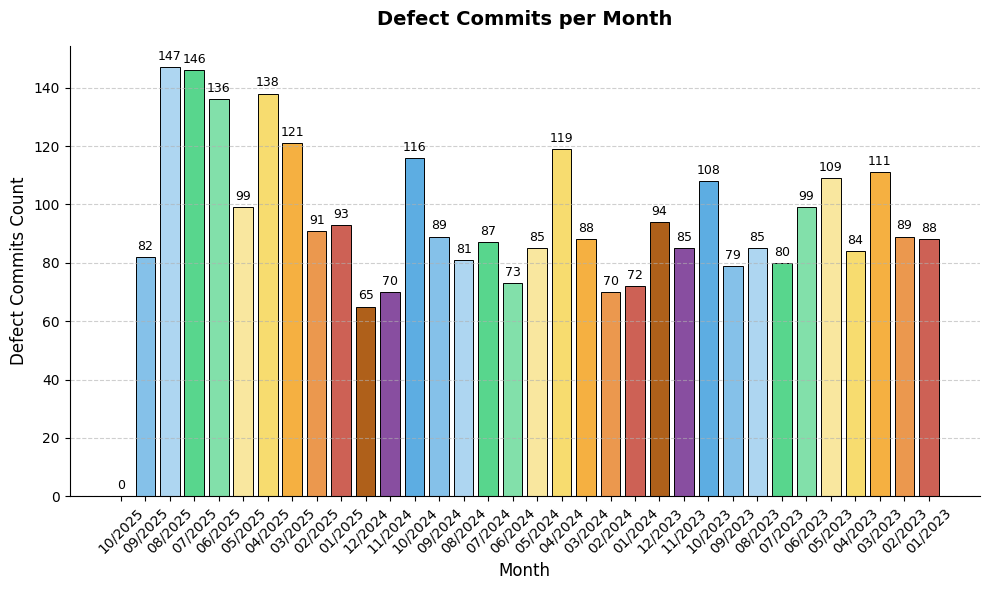

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

month = list(defect_per_month.keys())
counts = list(defect_per_month.values())

bar_colors = [
    "#5DADE2", "#85C1E9", "#AED6F1", "#58D68D",
    "#82E0AA", "#F9E79F", "#F7DC6F", "#F5B041",
    "#EB984E", "#CD6155", "#AF601A", "#884EA0"
]


# Create the bar chart
bars = ax.bar(month, counts, color=bar_colors, edgecolor="black", linewidth=0.7)

# Add counts above bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # small offset above bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9, color='black')
    
# Titles and labels
ax.set_title("Defect Commits per Month", fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Defect Commits Count", fontsize=12)

# X-axis formatting
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Grid and layout improvements
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Number of defects per month for the two files with the highest number of defects

Top 1 defect file: src/transformers/modeling_utils.py
Top 2 defect file: src/transformers/trainer.py


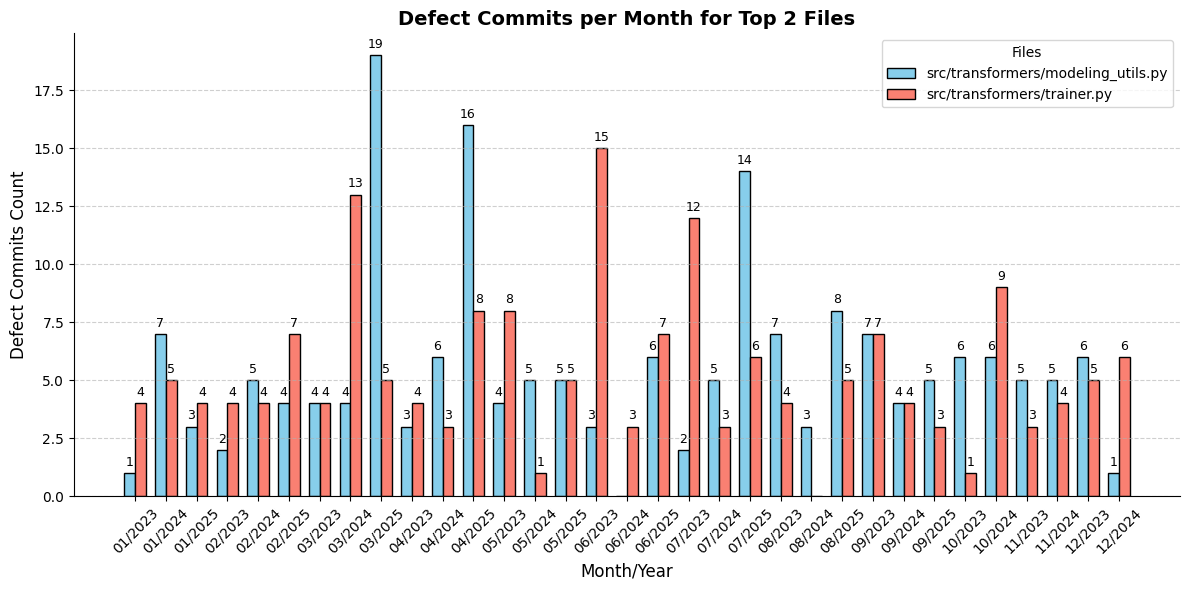

In [5]:
def parse_git_log(filepath):
    # Map short month names to numbers (used for date formatting)
    month_map = {
        "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06",
        "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"
    }

    # Read and group commits from the log file
    commits = _parse_commits(filepath)

    # Keep only commits that look like defect fixes >> {"fix", "bug", "error", "issue"}
    defect_commits = _filter_defect_commits(commits)

    # Count how many defects are linked to each file
    defect_counts = _count_defects_by_file(defect_commits)

    # Find the top 2 files with the most defects
    top_files = _get_top_files(defect_counts, top_n=2)

    # Print which files had the most defects
    _print_top_files(top_files)

    # Count how many defects happened per month for these top files
    defect_per_month = _get_defects_per_month(defect_commits, top_files, month_map)
    
    # Find which month had the highest defect count
    max_month_numbers = get_month_with_max_counts(defect_per_month)

    # Get the full month names (e.g., “Mar”) that match those max counts
    max_count_per_month = [k for k, v in month_map.items() if v in max_month_numbers]

    # Collect commit logs for those months and top files
    logs = get_commit_logs_by_file(defect_commits, top_files, max_count_per_month)

    # Return monthly defect data and logs for further review
    return defect_per_month, logs


def _parse_commits(filepath):
    # Read commits from the git log file and group lines under each commit header
    commits = {}
    current_commit = None

    with open(filepath, encoding='utf-8') as infile:
        for line in infile:
            line = line.strip()
            if not line:
                continue
            # Lines starting with a weekday as a new commit 
            if line[:3] in ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]:
                current_commit = line
                commits[current_commit] = []
            # All other lines belong to the current commit
            elif current_commit:
                commits[current_commit].append(line)

    return commits


def _filter_defect_commits(commits):
    return {
        commit: files
        for commit, files in commits.items()
        if any(word in get_commit_message(commit).lower() for word in defect_keywords)
    }


def _count_defects_by_file(defect_commits):
    # Count how often each file appears in defect-related commits
    file_counter = Counter()
    for files in defect_commits.values():
        file_counter.update(files)
    return dict(file_counter)


def _get_top_files(defect_counts, top_n=2):
    # Sort files by number of defects and get the top ones
    sorted_files = sorted(defect_counts.items(), key=lambda x: x[1], reverse=True)
    return [f for f, _ in sorted_files[:top_n]]


def _print_top_files(top_files):
    # Print a short summary of top defect-prone files
    for idx, file in enumerate(top_files, start=1):
        print(f"Top {idx} defect file: {file}")


def _get_defects_per_month(commits, top_files, month_map):
    # Count defects for each top file, grouped by month and year
    defect_per_month = {file: defaultdict(int) for file in top_files}

    for commit, files in commits.items():
        parts = commit.split()
        if len(parts) >= 5:
            mon, year = parts[1], parts[4]
            if mon in month_map:
                key = f"{month_map[mon]}/{year}"
                # Add counts only for the top defect-prone files
                for f in top_files:
                    if f in files:
                        defect_per_month[f][key] += 1

    # Convert defaultdicts to normal dicts before returning
    return {f: dict(counts) for f, counts in defect_per_month.items()}
    

def get_month_with_max_counts(defect_per_month):
    # Find which month (by number) had the most defects overall
    month_count = {}
    for counts in defect_per_month.values():
        for key, value in counts.items():
            month = key.split('/')[0] 
            if month in month_count:
                month_count[month] += value
            else:
                month_count[month] = value 
    # Return the month(s) that had the highest defect count
    if month_count:
        max_count = max(month_count.values())
        max_months = [m for m, v in month_count.items() if v == max_count]
        return max_months


def get_commit_logs_by_file(commits, top_files, max_count_per_month):
    # Gather commit messages for top files during the month(s) with most defects
    logs = []
    for commit, files in commits.items(): 
        if any(f in top_files for f in files):
            parts = commit.split()
            mon, year = parts[1], parts[4]
            if mon in max_count_per_month and year == "2025":
                logs.append(commit)

    # Return all relevant commit lines
    return logs


# Get parsed data (dict: {filename: {month: count}})
defect_data, logs = parse_git_log("git_log_output.txt")

# Extract the top two files and their monthly data
top_files = list(defect_data.keys())
file1, file2 = top_files[0], top_files[1]

counts1 = defect_data[file1]
counts2 = defect_data[file2]

# Get the sorted list of months (x-axis)
months = sorted(set(counts1.keys()) | set(counts2.keys()))

# Extract counts aligned with months (fill 0 if missing)
y1 = [counts1.get(m, 0) for m in months]
y2 = [counts2.get(m, 0) for m in months]

# Plot setup
x = np.arange(len(months))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, y1, width, label=file1, color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, y2, width, label=file2, color='salmon', edgecolor='black')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=9, color='black')


# Labels and formatting
ax.set_ylabel('Defect Commits Count', fontsize=12)
ax.set_xlabel('Month/Year', fontsize=12)
ax.set_title('Defect Commits per Month for Top 2 Files', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(months, rotation=45)
ax.legend(title='Files')
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
 

## Task 2

### Calculate LoC and NCC for all .py files in the repository

In [27]:
file_stats = {}

# Calculate LoC
for root, _, files in os.walk("transformers"):
    for file_name in files:
        if file_name.endswith(".py"):
            file_path = os.path.join(root, file_name)
            analysis = SourceAnalysis.from_file(file_path, "py", fallback_encoding="utf-8")
            file_stats[file_path.replace("\\", "/").replace("transformers/", "", 1)] = {
                "loc": analysis.code_count,
                "ncc": 0,
                "defects": 0,
            }

# Calculate NCC and number of defects
files_not_found = set()
with open("git_log_output.txt", encoding="utf-8") as infile:
    isDefectCommit = False
    for raw_line in infile:
        line = raw_line.strip()
        # Check it is a commit line
        if line[:3] in ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]:
            message = get_commit_message(line)
            if any(keyword in message.lower() for keyword in defect_keywords):
                isDefectCommit = True
            else:
                isDefectCommit = False
            continue

        # Check for file line
        elif len(line) > 0 and line.endswith(".py"):
            if line in file_stats:
                file_stats[line]["ncc"] += 1
                if isDefectCommit:
                    file_stats[line]["defects"] += 1
            else:
                # There may be files that were deleted or moved; track them
                files_not_found.add(line)
print(f"{len(files_not_found)} files from git log not found in LoC analysis.")

1096 files from git log not found in LoC analysis.


### Visualize the complexity hotspots

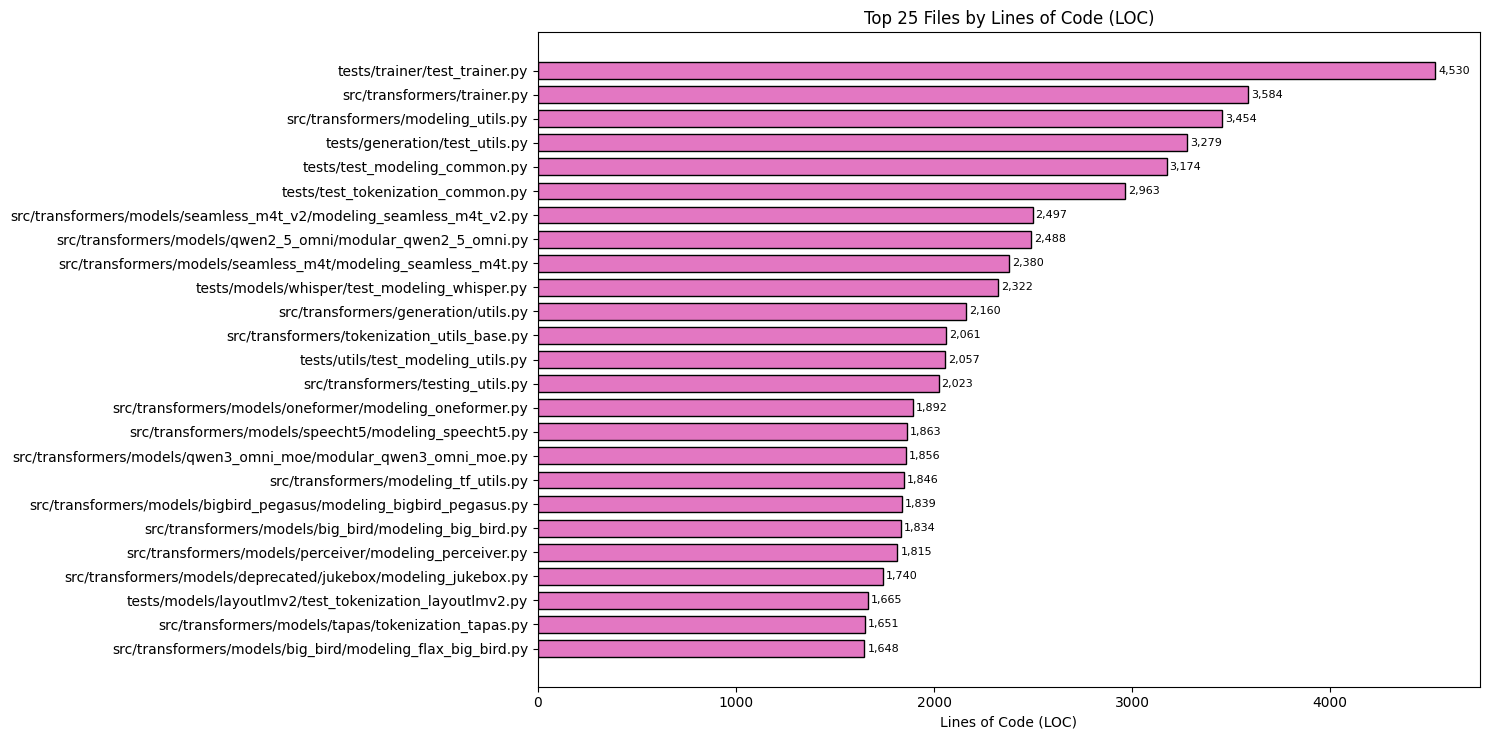

In [29]:
top_loc_files = set()


def plot_top_loc(stats_dict, top_n=25):
    # Convert the dictionary items into a list of (filename, loc_value) tuples
    data_list = [(filename, details["loc"]) for filename, details in stats_dict.items()]
    sorted_data = sorted(data_list, key=lambda item: item[1], reverse=True)
    top_data = sorted_data[:top_n]

    # Separate the data into filenames (labels) and LOC values (bars)
    filenames = [item[0] for item in top_data]
    top_loc_files.update(filenames)
    loc_values = [item[1] for item in top_data]

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(15, top_n * 0.3))  # Height is dynamic based on number of bars

    # Create the horizontal bar chart
    bars = ax.barh(filenames, loc_values, color="tab:pink", height=0.7, edgecolor="black")

    ax.set_title(f"Top {top_n} Files by Lines of Code (LOC)")
    ax.set_xlabel("Lines of Code (LOC)")

    ax.invert_yaxis()  # Put highest LOC files (which are first in the list) at the top

    # Add LOC values on the bars
    for bar in bars:
        ax.text(
            bar.get_width() + 15,  # x position
            bar.get_y() + bar.get_height() / 2,  # y position (center of the bar)
            f"{bar.get_width():,}",  # The text (LOC value with comma)
            va="center",  # Vertical alignment
            fontsize=8,
            color="black",
        )

    plt.tight_layout()
    plt.show()


plot_top_loc(file_stats, top_n=25)

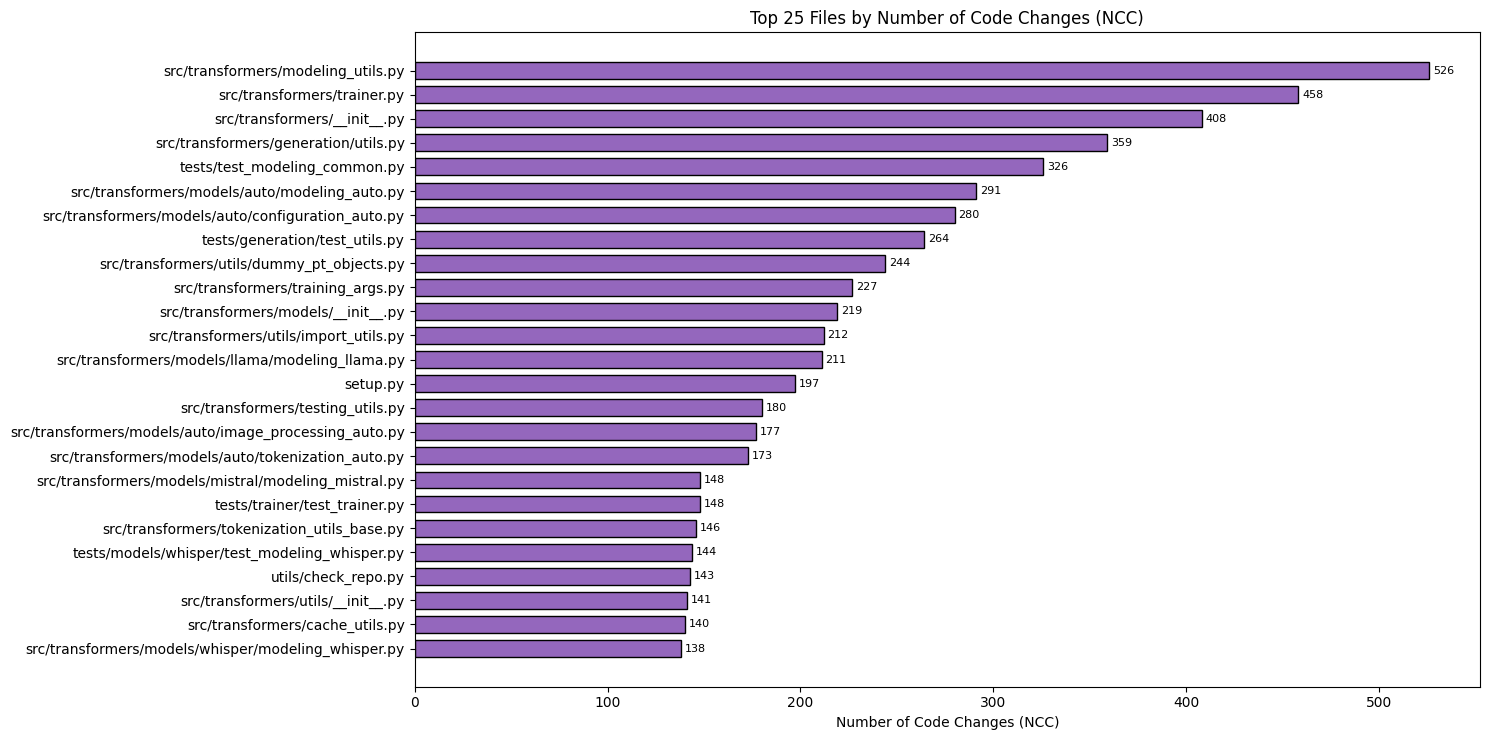

In [30]:
top_ncc_files = set()


def plot_top_ncc(stats_dict, top_n=25):
    # Convert the dictionary items into a list
    data_list = [(filename, details["ncc"]) for filename, details in stats_dict.items()]
    sorted_data = sorted(data_list, key=lambda item: item[1], reverse=True)
    top_data = sorted_data[:top_n]

    # Separate the data into filenames (labels) and NCC values (bars)
    filenames = [item[0] for item in top_data]
    top_ncc_files.update(filenames)
    ncc_values = [item[1] for item in top_data]

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(15, top_n * 0.3))  # Height is dynamic based on number of bars

    # Create the horizontal bar chart
    bars = ax.barh(filenames, ncc_values, color="tab:purple", height=0.7, edgecolor="black")

    ax.set_title(f"Top {top_n} Files by Number of Code Changes (NCC)")
    ax.set_xlabel("Number of Code Changes (NCC)")

    ax.invert_yaxis()  # Put highest NCC files (which are first in the list) at the top

    # Add NCC values on the bars
    for bar in bars:
        ax.text(
            bar.get_width() + 2,  # x position
            bar.get_y() + bar.get_height() / 2,  # y position (center of the bar)
            f"{bar.get_width():,}",  # The text (NCC value with comma)
            va="center",  # Vertical alignment
            fontsize=8,
            color="black",
        )

    plt.tight_layout()
    plt.show()


plot_top_ncc(file_stats, top_n=25)

Plotting 41 files


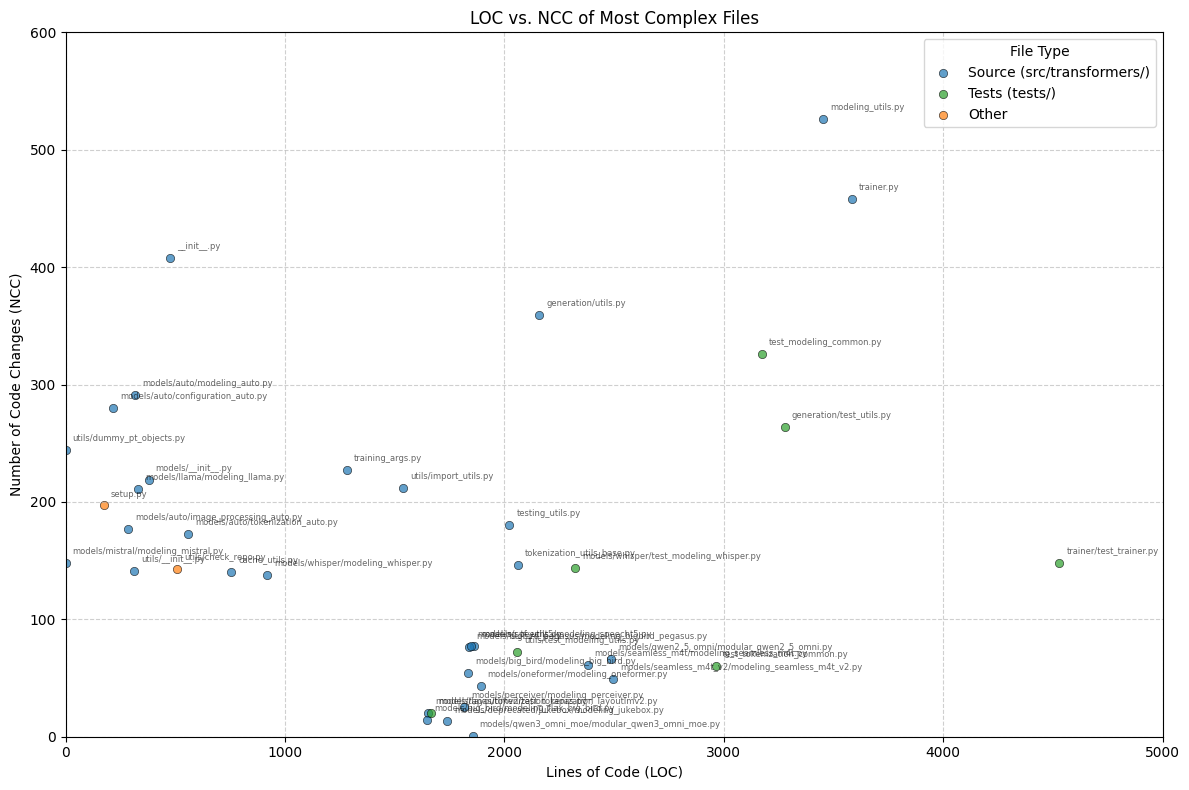

In [31]:
def plot_loc_vs_ncc_scatterplot(stats_dict, top_files_set):

    subset_dict = {k: stats_dict[k] for k in top_files_set}

    # Prepare data for plotting and labeling
    plot_data = []
    for filename, details in subset_dict.items():
        loc = details.get("loc", 0)
        ncc = details.get("ncc", 0)
        parsed_filename = filename
        # Classify file type and assign color
        if filename.startswith("src/transformers/"):
            file_type = "Source (src/transformers/)"
            color = "blue"
            parsed_filename = filename.split("/", 2)[2]
        elif filename.startswith("tests/"):
            file_type = "Tests (tests/)"
            color = "green"
            parsed_filename = filename.split("/", 1)[1]
        else:
            file_type = "Other"
            color = "orange"

        plot_data.append(
            {"filename": parsed_filename, "loc": loc, "ncc": ncc, "file_type": file_type, "color": color}
        )

    print(f"Plotting {len(subset_dict)} files")
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot each file type separately to create distinct legend entries
    for file_type, color in [
        ("Source (src/transformers/)", "tab:blue"),
        ("Tests (tests/)", "tab:green"),
        ("Other", "tab:orange"),
    ]:
        # Filter data for the current file type
        type_data = [d for d in plot_data if d["file_type"] == file_type]
        type_loc = [d["loc"] for d in type_data]
        type_ncc = [d["ncc"] for d in type_data]

        ax.scatter(
            type_loc,
            type_ncc,
            color=color,
            edgecolors="black",
            alpha=0.7,
            linewidths=0.5,
            label=file_type,
        )  # Label for legend

        # Add labels for points within the axis limits
        for d in type_data:
            ax.annotate(
                d["filename"],  # Show only the base filename for conciseness
                (d["loc"], d["ncc"]),
                xytext=(5, 5),  # Offset the text
                textcoords="offset points",
                fontsize=6,
                alpha=0.6,
                ha="left",
                va="bottom",
            )

    ax.set_title("LOC vs. NCC of Most Complex Files")
    ax.set_xlabel("Lines of Code (LOC)")
    ax.set_ylabel("Number of Code Changes (NCC)")
    ax.set_xlim(0, 5000)
    ax.set_ylim(0, 600)

    ax.legend(title="File Type", loc="upper right")
    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

top_files = top_loc_files.union(top_ncc_files)
plot_loc_vs_ncc_scatterplot(file_stats, top_files)

### Correlation between the two complexity measures

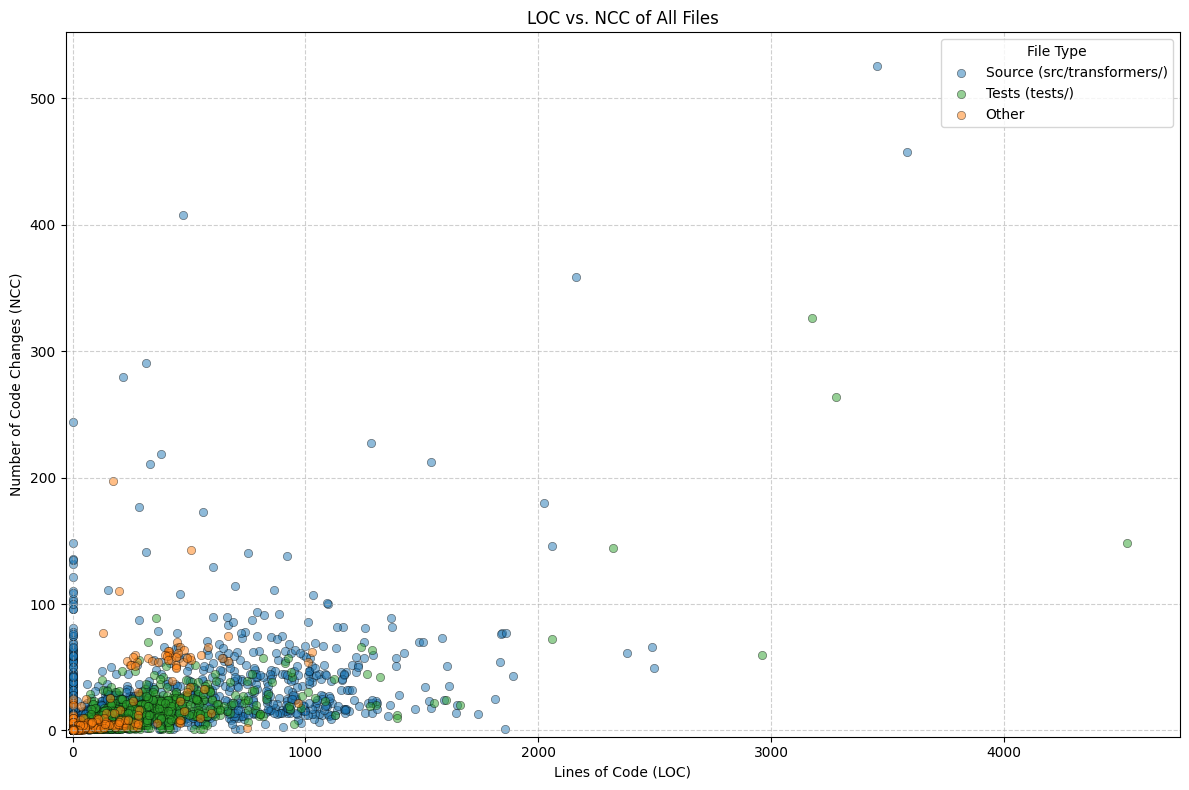

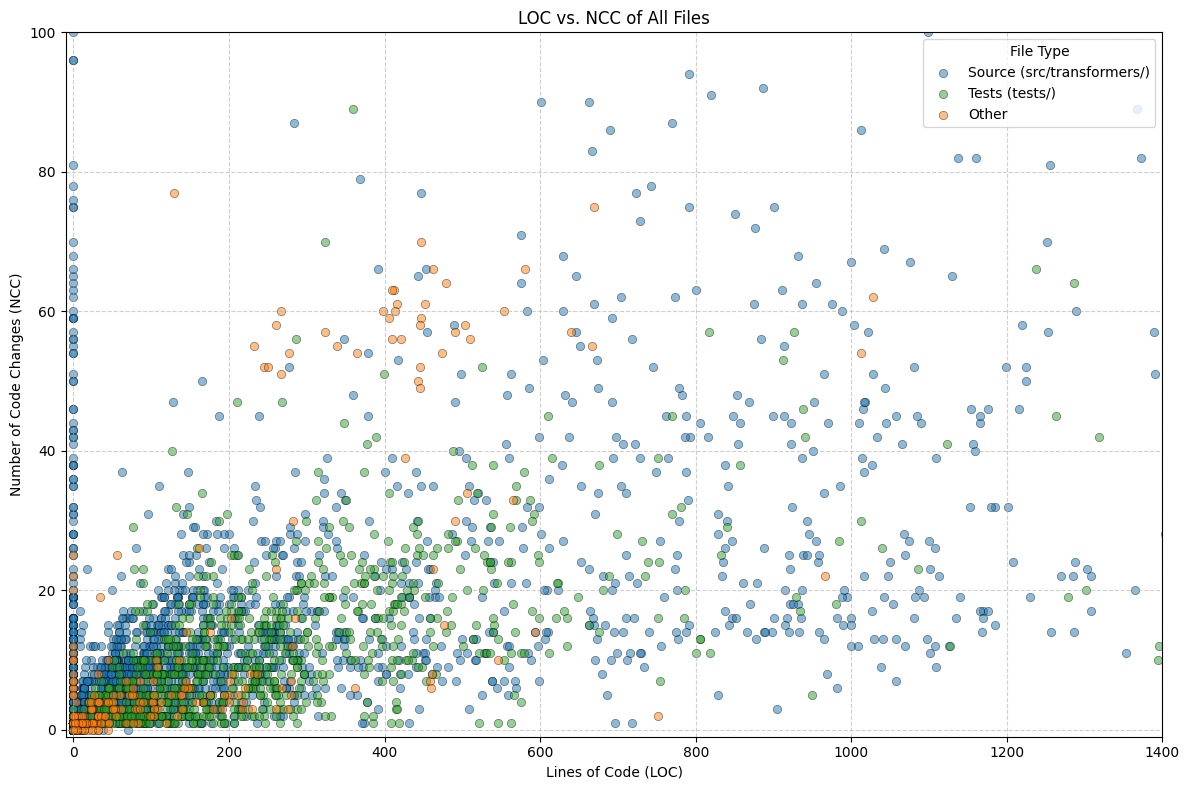

In [28]:
def plot_loc_vs_ncc_scatterplot2(stats_dict, subset=False):

    # Prepare data for plotting and labeling
    plot_data = []
    for filename, details in stats_dict.items():
        loc = details.get("loc", 0)
        ncc = details.get("ncc", 0)
        parsed_filename = filename
        # Classify file type and assign color
        if filename.startswith("src/transformers/"):
            file_type = "Source (src/transformers/)"
            color = "blue"
            parsed_filename = filename.split("/", 2)[2]
        elif filename.startswith("tests/"):
            file_type = "Tests (tests/)"
            color = "green"
            parsed_filename = filename.split("/", 1)[1]
        else:
            file_type = "Other"
            color = "orange"

        plot_data.append(
            {
                "filename": parsed_filename,
                "loc": loc,
                "ncc": ncc,
                "file_type": file_type,
                "color": color,
            }
        )

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot each file type separately to create distinct legend entries
    for file_type, color in [
        ("Source (src/transformers/)", "tab:blue"),
        ("Tests (tests/)", "tab:green"),
        ("Other", "tab:orange"),
    ]:
        # Filter data for the current file type
        type_data = [d for d in plot_data if d["file_type"] == file_type]
        type_loc = [d["loc"] for d in type_data]
        type_ncc = [d["ncc"] for d in type_data]

        ax.scatter(
            type_loc,
            type_ncc,
            color=color,
            edgecolors="black",
            alpha=0.5,
            linewidths=0.5,
            label=file_type,
        )  # Label for legend

    ax.set_title("LOC vs. NCC of All Files")
    ax.set_xlabel("Lines of Code (LOC)")
    ax.set_ylabel("Number of Code Changes (NCC)")

    if subset:
        ax.set_xlim(-10, 1400)
        ax.set_ylim(-1, 100)
    else:
        ax.set_xlim(-30),
        ax.set_ylim(-5)

    ax.legend(title="File Type", loc="upper right")
    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()


plot_loc_vs_ncc_scatterplot2(file_stats)
plot_loc_vs_ncc_scatterplot2(file_stats, True)

### "Files with higher complexity tend to be more defective"

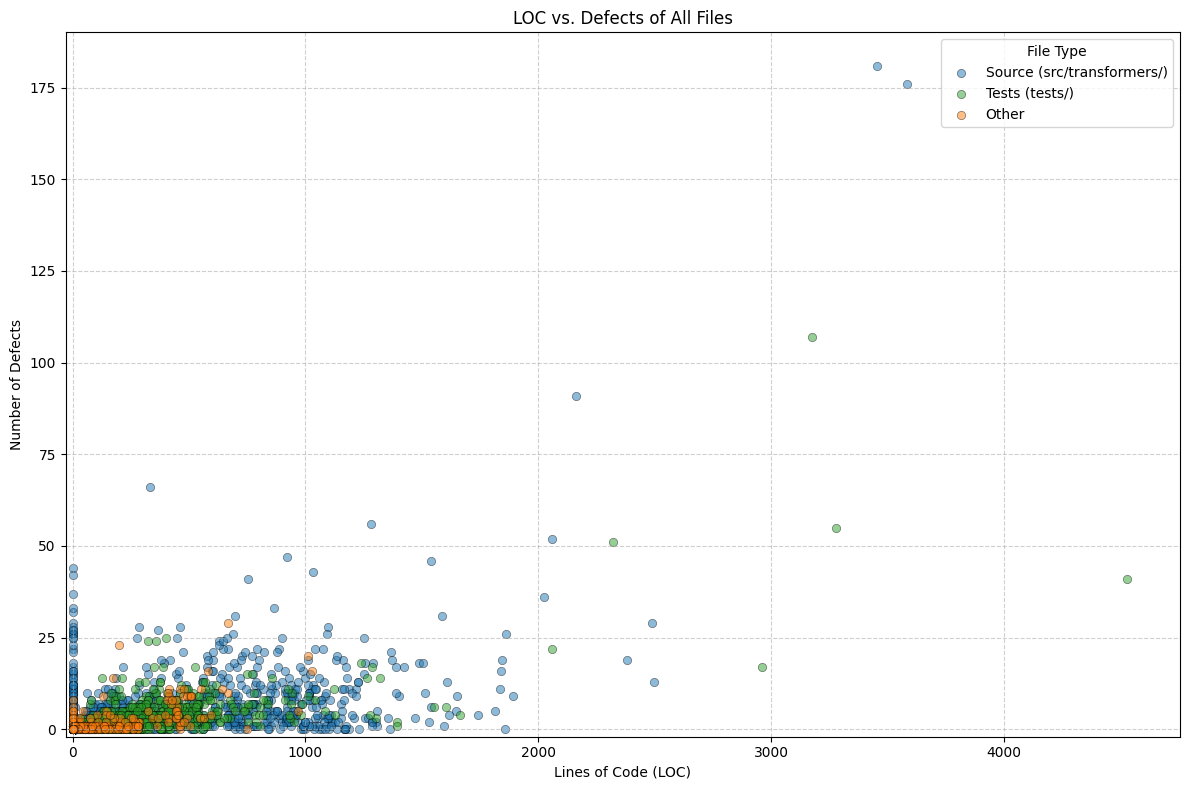

In [40]:
def plot_loc_vs_defects_scatterplot(stats_dict):

    # Prepare data for plotting and labeling
    plot_data = []
    for filename, details in stats_dict.items():
        loc = details.get("loc", 0)
        defects = details.get("defects", 0)
        parsed_filename = filename
        # Classify file type and assign color
        if filename.startswith("src/transformers/"):
            file_type = "Source (src/transformers/)"
            color = "blue"
            parsed_filename = filename.split("/", 2)[2]
        elif filename.startswith("tests/"):
            file_type = "Tests (tests/)"
            color = "green"
            parsed_filename = filename.split("/", 1)[1]
        else:
            file_type = "Other"
            color = "orange"

        plot_data.append(
            {
                "filename": parsed_filename,
                "loc": loc,
                "defects": defects,
                "file_type": file_type,
                "color": color,
            }
        )

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot each file type separately to create distinct legend entries
    for file_type, color in [
        ("Source (src/transformers/)", "tab:blue"),
        ("Tests (tests/)", "tab:green"),
        ("Other", "tab:orange"),
    ]:
        # Filter data for the current file type
        type_data = [d for d in plot_data if d["file_type"] == file_type]
        type_loc = [d["loc"] for d in type_data]
        type_defects = [d["defects"] for d in type_data]

        ax.scatter(
            type_loc,
            type_defects,
            color=color,
            edgecolors="black",
            alpha=0.5,
            linewidths=0.5,
            label=file_type,
        )  # Label for legend

    ax.set_title("LOC vs. Defects of All Files")
    ax.set_xlabel("Lines of Code (LOC)")
    ax.set_ylabel("Number of Defects")

    ax.set_xlim(-30),
    ax.set_ylim(-2)

    ax.legend(title="File Type", loc="upper right")
    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

plot_loc_vs_defects_scatterplot(file_stats)

## Task 3

### Calculate the logical coupling for each file pair in the repository

In [16]:
class LogicalCouplingVisualizer:
    def __init__(self, isTest=False):
        self.logical_coupling = defaultdict(int)
        self.git_log_path = 'git_log_output.txt'
        self.isTest = isTest
        # Start processing the git log to map logical coupling
        self.map_logical_coupling()

    def map_logical_coupling(self):
        with open(self.git_log_path, encoding='utf-8') as infile:
            commit_files = []
            for line in infile:
                if line == "\n":
                    self._calculate_logical_coupling(commit_files)
                    commit_files.clear()
                    continue
                elif line[:3] in ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]:
                    continue
                commit_files.append(line.strip())

    def get_logical_coupling(self):
        return self.logical_coupling

    def _calculate_logical_coupling(self, commit_files):
        # For each unique pair of files in the commit, increment their coupling count
        unique_files = set(commit_files)
        for file1 in unique_files:
            for file2 in unique_files:
                if file1 != file2:
                    if self.isTest and not (file1.startswith("tests/") or file2.startswith("tests/")):
                        continue
                    pair = tuple(sorted((file1, file2)))
                    self.logical_coupling[pair] += 1

    # Select the top coupled pairs by sorting them by their coupling count
    def _sort_coupled_pairs(self):
        return sorted(self.logical_coupling.items(), key=lambda x: x[1], reverse=True)[:10]

    def draw_logical_coupling_bar_chart(self):
        # Get the last 3 segments of the path
        get_filename = lambda path: '/'.join(path.split('/')[-3:])

        top_coupled_pairs = self._sort_coupled_pairs()
        pairs = [f"{get_filename(file1)} & {get_filename(file2)}" for (file1, file2), _ in top_coupled_pairs]
        counts = [count for _, count in top_coupled_pairs]
        _, ax = plt.subplots(figsize=(12, 6))
        _ = ax.barh(pairs, counts, color="red", edgecolor='black')
        ax.set_title(f"Top 10 Most Logically Coupled File Pairs{' (Test Files)' if self.isTest else ''}", fontsize=14, fontweight='bold')
        ax.set_xlabel('Number of Co-Changes', fontsize=12)
        ax.set_ylabel('File Pairs', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()

    

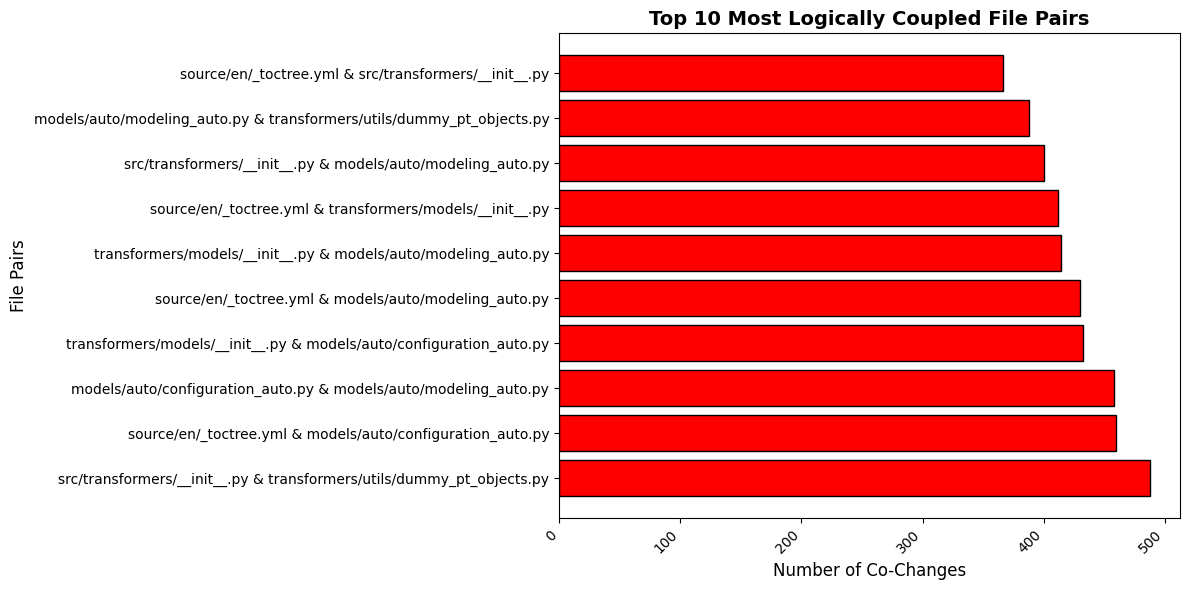

In [18]:
# Map logical coupling for all files
logical_coupling = LogicalCouplingVisualizer()
# Draw the bar chart for the top coupled file pairs
logical_coupling.draw_logical_coupling_bar_chart()

### Relation between src/transformers/__init__.py & transformers/utils/dummy_pt_objects.py

The `__init__.py` file in the transformers package defines a dictionary called `_import_structure`, which specifies the base objects and modules that are exposed by the package. It defines which base objects are exposed by the package.

The `dummy_pt_objects.py` file, on the other hand, defines the objects that `_import_structure` references.

#### Why they're coupled?
* Changes in `dummy_pt_objects.py` require updates to `_import_structure` in `__init__.py` to maintain the imports.
* It creates a functional dependency that explains why these two files often change together in commits.

### Repeat it, but consider only file pairs where one file is a Python test file

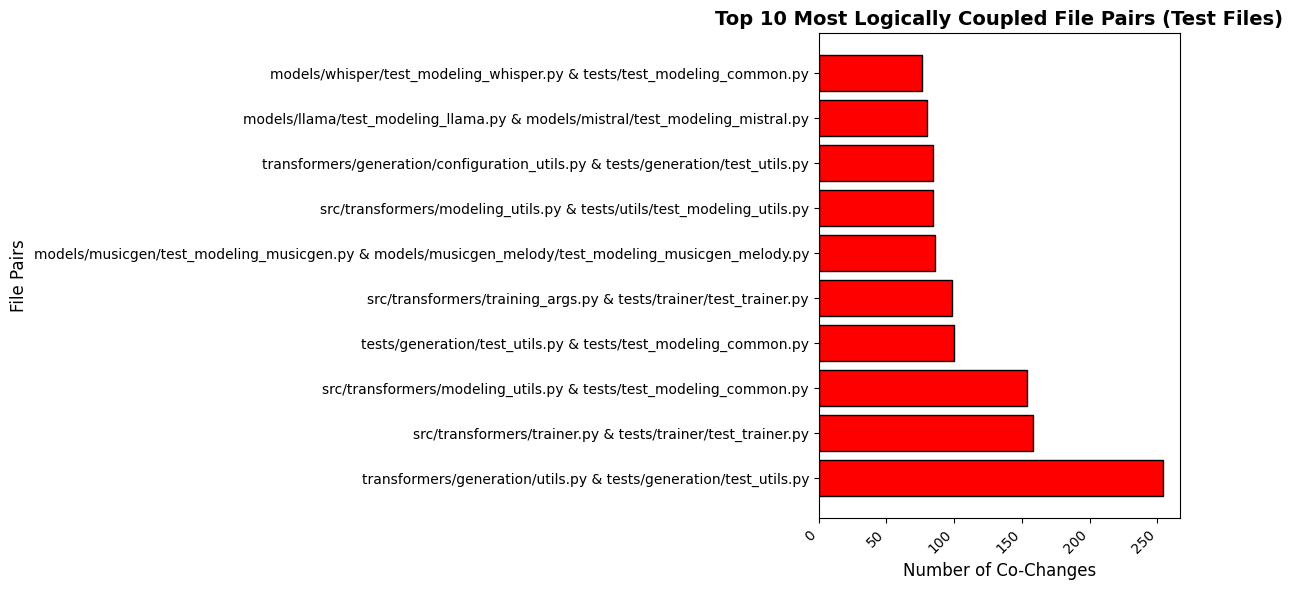

In [17]:
# Draw the bar chart for the top coupled test file pairs
test_logical_coupling = LogicalCouplingVisualizer(isTest=True)
test_logical_coupling.draw_logical_coupling_bar_chart()

### Why is that happening?
When a non-test file changes, developers often update the corresponding test to reflect the changes. The test is coupled to the implementation it verifies.

### Discuss at least three (3) methods for selecting the most “related” test file given a (non-test) .py file

### Method 1: Import Analysis
The first method identifies the most related test files through the analysis of the file's imports. In this approach, all test files in the project are inspected to determine which production modules they reference through their import statements. Because unit tests import the functions, classes or modules aimed to verify, is possible to track from a given source file which test file is meant to cover.

### Method 2: Files Coupling
This second method, instead relies on logical coupling between a test file and a non-test file exactly as done in the past section of the third exercise. From the Git commit log, it is possible to count how many times both a test and a non-test file have been modified together. For a input `.py` file, the most related file is therefore the one with the highest co-change count.

### Method 3: Semantic Similarity
This third method uses natural language similarity between the implementation file and test file names, class name or identifiers. Instead of relying on imports or commit history, this method compares natural-language information extracted from filenames, class names. The intuition is that normally test files often contain naming patterns derived from the modules they test such as: `test_example.py` corresponds to the production module `example.py`.

### Select two of the three test placement methods you proposed above and implement them in Python

### Method 1: Files Coupling

In [19]:
def get_selected_file(input_file, includeExamples=True):
    matching_paths = set()
    logical_coupling_map = test_logical_coupling.get_logical_coupling()

    # Filter out the example files if not included
    if not includeExamples:
        logical_coupling_map = {
            (file1, file2): count
            for (file1, file2), count in logical_coupling_map.items()
            if not (file1.startswith("examples/") or file2.startswith("examples/"))
        } 

    for (file1, file2), _ in logical_coupling_map.items():
        # Compare only the filename part
        if os.path.basename(file1) == input_file:
            matching_paths.add(file1)

        if os.path.basename(file2) == input_file:
            matching_paths.add(file2)

    matching_paths = list(matching_paths)

    if len(matching_paths) == 0:
        print("No matching files found in the logical coupling map.")
    elif len(matching_paths) == 1:
        return matching_paths[0]
    else:
        print("Multiple files match your input:")
        for i, path in enumerate(matching_paths):
            print(f"{i+1}. {path}")
        choice = int(input("Select the correct file (1-N): "))
        return matching_paths[choice - 1]

In [ ]:

# Python input file
input_file = input("Enter the input file (e.g. example.py): ").strip()

selected_file = get_selected_file(input_file)

if selected_file:
    related_files = {}
    logical_coupling_map = test_logical_coupling.get_logical_coupling()
    for (file1, file2), count in logical_coupling_map.items():
        if file1 == selected_file and file2.startswith("test"):
            related_files[file2] = related_files.get(file2, 0) + count
        if file2 == selected_file and file1.startswith("test"):
            related_files[file1] = related_files.get(file1, 0) + count


    if not related_files:
        print("No test files coupled with this file.")
    else:
        most_related_test = max(related_files, key=related_files.get)
        print(f"Most related test file: {most_related_test}")


Multiple files match your input:
1. examples/research_projects/synthid_text/utils.py
2. examples/research_projects/seq2seq-distillation/utils.py
3. examples/legacy/seq2seq/utils.py
4. examples/research_projects/visual_bert/utils.py
5. examples/research_projects/lxmert/utils.py
6. src/transformers/data/processors/utils.py
7. src/transformers/generation/utils.py
8. examples/research_projects/distillation/utils.py
Most related test file: tests/generation/test_utils.py


### Method 2: Semantic Similarity
For this second implementation, the files inside the directory `examples/` are going to be filtered out as it is not possible to map the input `.py` file with its corresponding test file.

In [27]:
# Python input file
input_file = input("Enter the input file (e.g. example.py): ").strip()

selected_file = get_selected_file(input_file, includeExamples=False)

if selected_file:
    file_name = os.path.basename(selected_file)
    file_name = f"test_{file_name}"

    test_directory = os.path.dirname(
        selected_file.replace("src/transformers/", "tests/", 1)
    )
    expected_test_path = os.path.join(test_directory, file_name).replace("\\", "/")
    print(f"Corresponding source file: {expected_test_path}")

    

Multiple files match your input:
1. src/transformers/data/processors/utils.py
2. src/transformers/generation/utils.py
Corresponding source file: tests/generation/test_utils.py
